### Direct Open Loop Controller Analysis

This notebook contains the analysis of the direct open loop controller across temperatures.

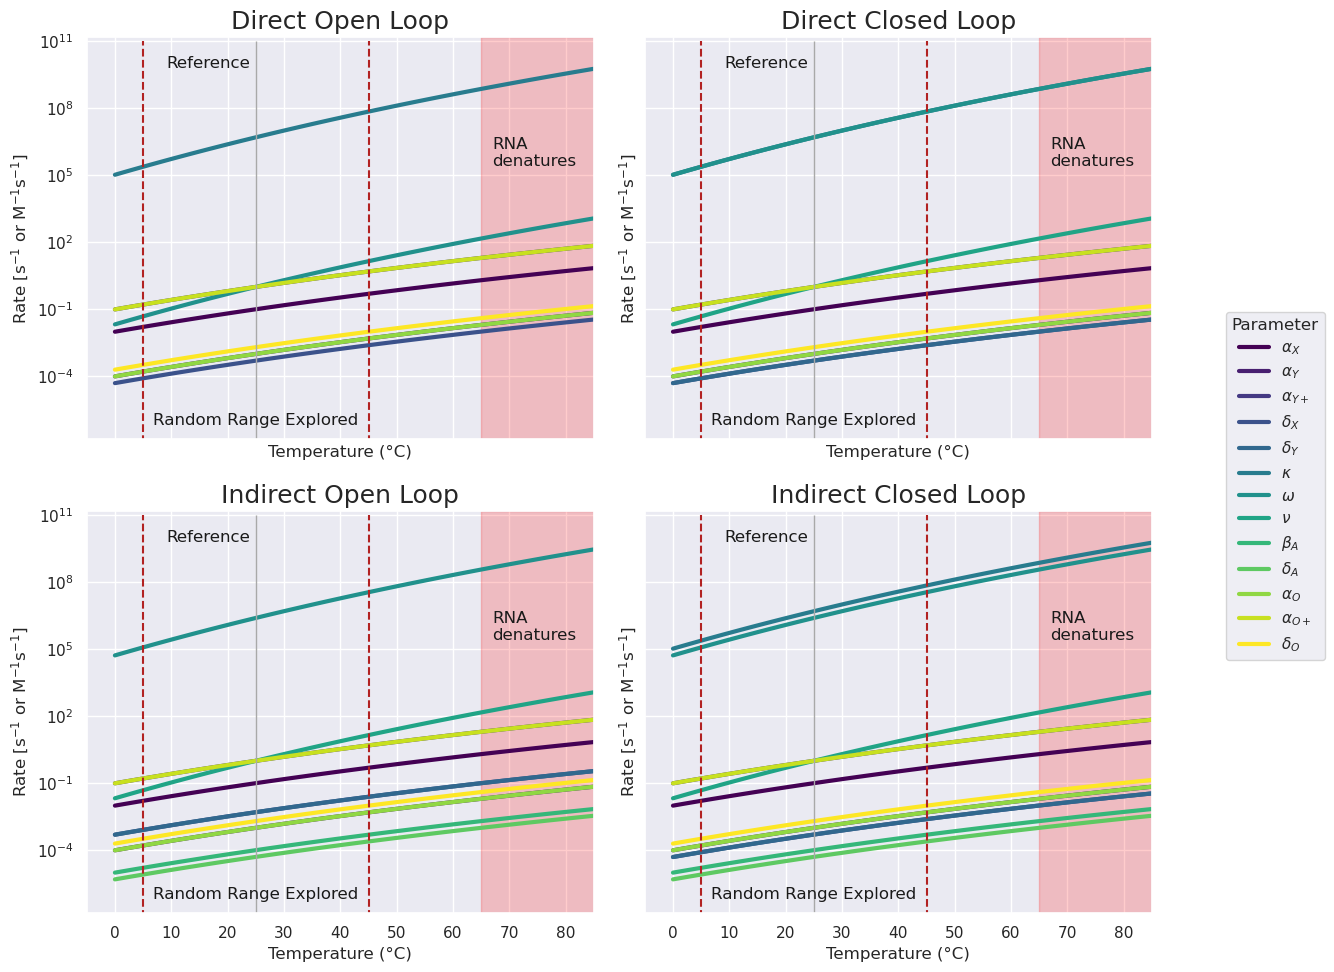

In [1]:
import import_ipynb
from kinetic_parameters import rate

In [7]:
rate(controller="direct_open_loop", temperature_C=25)

{'alpha_X': 0.1,
 'alpha_Y': 0.001,
 'alpha_Y+': 1.0,
 'delta_X': 0.0005,
 'delta_Y': 0.0,
 'kappa': 5000000.0,
 'omega': 1.0,
 'nu': nan,
 'beta_A': nan,
 'delta_A': nan,
 'alpha_O': 0.001,
 'alpha_O+': 1.0,
 'delta_O': 0.002}

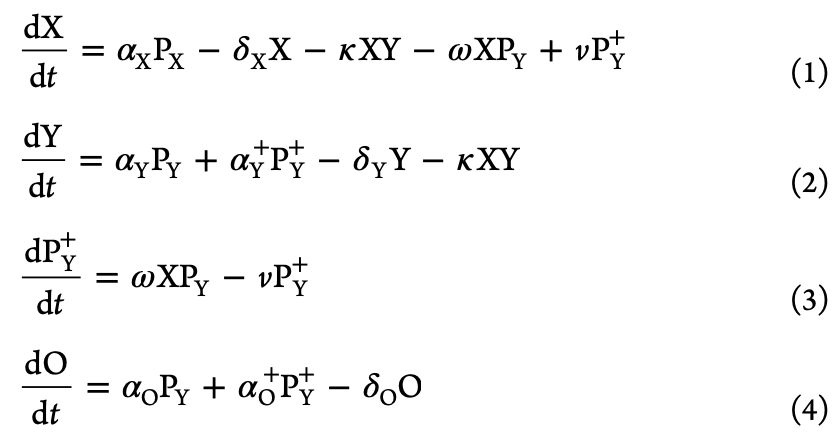

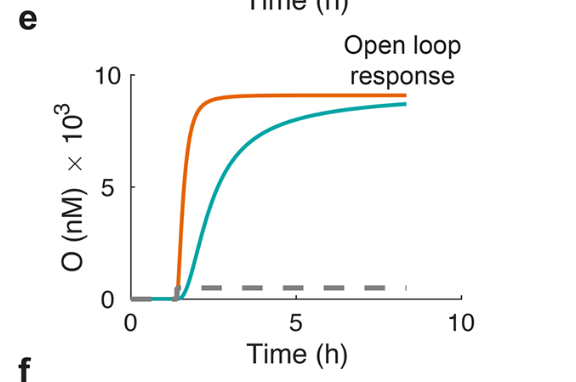

Looking at orange line

In [ ]:
# PX (0, 6, 12, 18, 24, or 30 nM)
#Inital Conditions: # X, Y, A, O, and PY+ = 0 nM and PY = 20 nM unless otherwise specified.

In [ ]:
# return the value over time 
#inital conditons 
# 10 hours total is 600 min 

In [8]:
# reference signal as (αO+αX)/(δOαY+) PX

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [182]:
# how to grab the parameters from the rate equation:
# Load parameters
params = rate(controller="direct_open_loop", temperature_C=25)

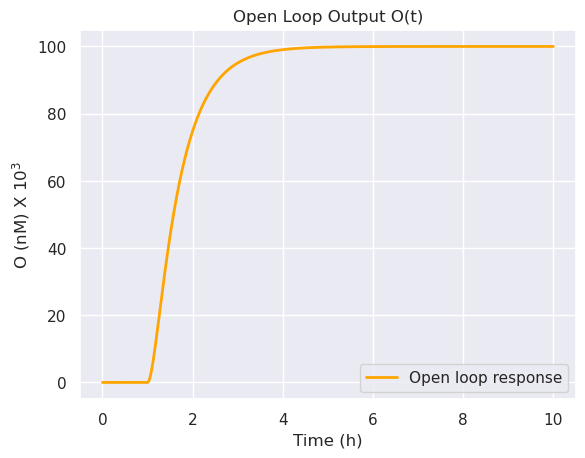

In [183]:
# Time in minutes and seconds
t_min = np.linspace(0, 600, 1000)        # for plotting
t_sec = t_min * 60                       # for simulation

# Parameters hard coded because incorrect sheet still, will just need to edit this one sheet correct. I think the above is right
alpha_X = 0.1          # s^-1
alpha_Y = 0.001        # s^-1
alpha_Y_plus = 1.0     # s^-1
delta_X = 0.0005       # s^-1
delta_Y = 0.0005       # s^-1
kappa = 0              # M^-1 s^-1
omega = 5e6            # M^-1 s^-1
v = 1.0                # s^-1
alpha_O = 0.001        # s^-1
alpha_O_plus = 1     # s^-1
delta_O = 0.002        # s^-1

P_y = 20e-9  # constant

def direct_open_loop(z, t):
    X, Y, P_plus, O = z
    
    if t >= 3600 :
        P_x = 10e-9
    else:
        P_x = 0
    
    dX_dt = alpha_X * P_x - delta_X * X - kappa * X * Y - omega * X * P_y + v * P_plus
    dY_dt = alpha_Y * P_y + alpha_Y_plus * P_plus - delta_Y * Y - kappa * X * Y
    dPp_dt = omega * X * P_y - v * P_plus
    dO_dt = alpha_O * P_y + alpha_O_plus * P_plus - delta_O * O
    return [dX_dt, dY_dt, dPp_dt, dO_dt]

# Initial conditions
z0 = [0, 0, 0, 0]

# Solve ODE system
sol = odeint(direct_open_loop, z0, t_sec, atol=1e-10, rtol=1e-10)

X, Y, P_plus, O = sol.T
#print(O)

# Plot converted back to nM and time in hours
plt.plot(t_sec / 3600, O * 1e9 / 1000, color='orange', linewidth=2, label="Open loop response")
plt.xlabel("Time (h)")
plt.ylabel("O (nM) X $10^3$")
plt.title("Open Loop Output O(t)")
plt.legend();

## OFF BY A FACTOR OF 10??

In [212]:
def dol_solution(params):
    """
    function to get data frame for open loop
    """
    alpha_X      = params.get("alpha_X", 0.1)
    alpha_Y      = params.get("alpha_Y", 0.001)
    alpha_Y_plus = params.get("alpha_Y+", 1.0)    
    delta_X      = params.get("delta_X", 0.0005)
    delta_Y      = params.get("delta_Y", 0.0005)
    kappa        = params.get("kappa", 0.0)
    omega        = params.get("omega", 5e6)
    v            = params.get("nu", 1.0)
    alpha_O      = params.get("alpha_O", 0.001)
    alpha_O_plus = params.get("alpha_O+", 1.0)    
    delta_O      = params.get("delta_O", 0.002)

    # Initial conditions
    P_y = 20e-9
    X0  = 0
    Y0  = 0
    Pp0 = 0
    O0  = 0
    variable0  = [X0, Y0, Pp0, O0]
    
    # Time vector
    t_min   = np.linspace(0, 600, 1000)
    t_sec   = t_min * 60.0
    
    def direct_open_loop(variable, t):
        X, Y, P_plus, O = variable
        if t >= 3600 :
            P_x = 10e-9
        else:
            P_x = 0
            
        dX_dt = alpha_X * P_x - delta_X * X - kappa * X * Y - omega * X * P_y + v * P_plus
        dY_dt = alpha_Y * P_y + alpha_Y_plus * P_plus - delta_Y * Y - kappa * X * Y
        dPp_dt = omega * X * P_y - v * P_plus
        dO_dt = alpha_O * P_y + alpha_O_plus * P_plus - delta_O * O
        
        return [dX_dt, dY_dt, dPp_dt, dO_dt]
    
    # Solve ODE system
    
    sol = odeint(direct_open_loop, variable0, t_sec)
    X, Y, P_plus, O = sol.T
    
    # Build and return DataFrame
    df = pd.DataFrame({
        "time[s]": t_sec,
        "X":       X,
        "Y":       Y,
        "P_Y+":    P_plus,
        "O":       O
    })
    return df

In [219]:
params = {
    "alpha_X": 0.1,
    "alpha_Y": 0.001,
    "alpha_Y_plus": 1.0,
    "delta_X": 0.0005,
    "delta_Y": 0.0005,
    "kappa": 0.0,
    "omega": 5e6,
    "v": 1.0,
    "alpha_O": 0.001,
    "alpha_O_plus": 1.0,
    "delta_O": 0.002,
}

df = dol_solution(params)
print(df.head())

      time[s]    X             Y  P_Y+             O
0    0.000000  0.0  0.000000e+00   0.0  0.000000e+00
1   36.036036  0.0  7.142984e-10   0.0  6.958409e-10
2   72.072072  0.0  1.415837e-09   0.0  1.343196e-09
3  108.108108  0.0  2.104846e-09   0.0  1.945483e-09
4  144.144144  0.0  2.781590e-09   0.0  2.506236e-09


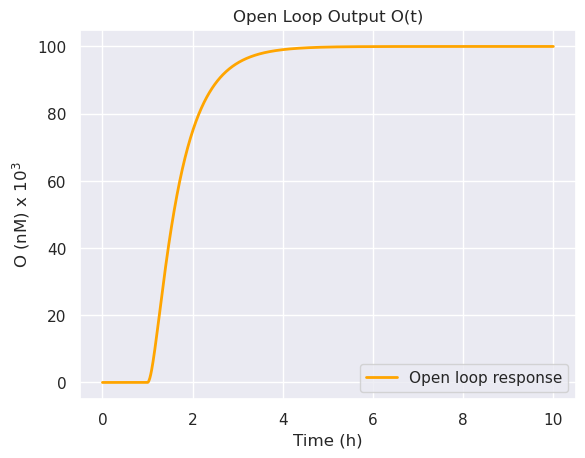

In [220]:
df = dol_solution(params)

# 2) Convert time to hours and O to nM
df['time_h'] = df['time[s]'] / 3600
df['O_nM']   = df['O'] * 1e9 / 1000

plt.plot(df['time_h'], df['O_nM'], color='orange', linewidth=2, label="Open loop response")
plt.xlabel("Time (h)")
plt.ylabel("O (nM) x $10^3$")
plt.title("Open Loop Output O(t)")
plt.legend();

In [215]:
param = rate(controller="direct_open_loop", temperature_C=25)
print(param)

{'alpha_X': 0.1, 'alpha_Y': 0.001, 'alpha_Y+': 1.0, 'delta_X': 0.0005, 'delta_Y': 0.0, 'kappa': 5000000.0, 'omega': 1.0, 'nu': nan, 'beta_A': nan, 'delta_A': nan, 'alpha_O': 0.001, 'alpha_O+': 1.0, 'delta_O': 0.002}


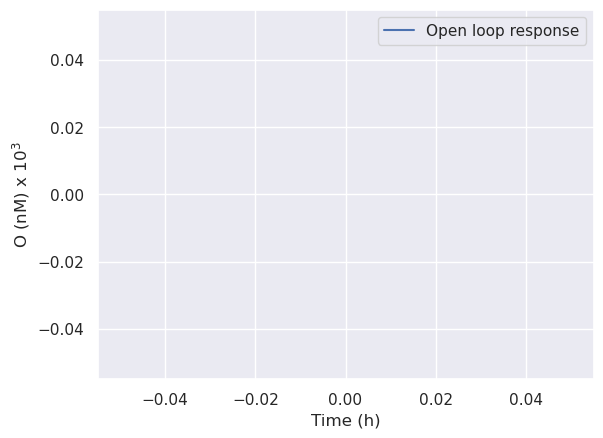

In [217]:
df = dol_solution(param)

# 2) Convert time to hours and O to nM
df['time_h'] = df['time[s]'] / 3600
df['O_nM']   = df['O'] * 1e9 / 1000

plt.plot(df['time_h'], df['O_nM'], label="Open loop response")
plt.xlabel("Time (h)")
plt.ylabel("O (nM) x $10^3$")
plt.legend();

In [ ]:
#function name needs to be dol_solutions
#and use a single dictionary called “params” as the input
#params can look anything like: params = {“temperature” : 25, “X_init” : 1, “A_init” : 0 ….}
#please have these functions return a single pandas dataframe with columns: time[s], X, Y, A, P_Y+, O

In [ ]:
# final code line: dol_solution(params)